In [1]:
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation, Dropout, multiply, Lambda, add, concatenate, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50
from keras.optimizers import SGD
from keras.callbacks import TensorBoard

In [2]:
import os
import cv2
import numpy as np


dataset_path = "/kaggle/input/fvc-db/DB2_B/EnhancedImages"

def load_fingerprint_images(dataset_path):
    images = {} 
    for filename in sorted(os.listdir(dataset_path)):
        if filename.endswith(".tif.png"):
            # Extract finger ID (e.g., '101' from '101_1.tif')
            finger_id = filename.split('_')[0]
            if finger_id not in images:
                images[finger_id] = []
            
            # Read and preprocess the image
            img = cv2.imread(os.path.join(dataset_path, filename), cv2.IMREAD_GRAYSCALE)
            
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img, (224, 224))  # Resize for ResNet50
            images[finger_id].append(img)
    
    return images

fingerprint_images = load_fingerprint_images(dataset_path)
print(f"Loaded {len(fingerprint_images)} fingers.")


Loaded 10 fingers.


In [4]:
import os
import cv2
import numpy as np


dataset_path = "/kaggle/input/all-dbs/Enh_DB3"

def load_fingerprint_images(dataset_path):
    images = {} 
    for filename in sorted(os.listdir(dataset_path)):
        if filename.endswith(".tif.png"):
            # Extract finger ID (e.g., '101' from '101_1.tif')
            finger_id = filename.split('_')[0]
            if finger_id not in images:
                images[finger_id] = []
            
            # Read and preprocess the image
            img = cv2.imread(os.path.join(dataset_path, filename), cv2.IMREAD_GRAYSCALE)
            
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = cv2.resize(img, (224, 224))  # Resize for ResNet50
            images[finger_id].append(img)
    
    return images

fingerprint_images_2 = load_fingerprint_images(dataset_path)
fingerprint_images_3=load_fingerprint_images('/kaggle/input/all-dbs/Enh_DB4')
# fp_images = fingerprint_images + fingerprint_images_2
merged_dict = {**fingerprint_images, **fingerprint_images_2,**fingerprint_images_3}
print(f"Loaded {len(merged_dict)} fingers.")


Loaded 30 fingers.


In [12]:
fingerprint_images = merged_dict

In [13]:
np.unique(fingerprint_images['101'][0])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  32,  33,  34,  35,  36,  37,  38,  40,  41,
        42,  44,  45,  46,  47,  48,  49,  50,  51,  53,  54,  55,  56,
        58,  59,  61,  62,  63,  64,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        88,  89,  90,  91,  92,  94,  95,  96,  97,  98, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 110, 111, 112, 114, 115, 116, 118,
       119, 120, 122, 123, 124, 125, 126, 128, 129, 131, 132, 133, 135,
       136, 137, 138, 139, 140, 141, 143, 144, 145, 147, 148, 149, 150,
       151, 152, 153, 155, 157, 158, 159, 160, 161, 162, 164, 165, 166,
       167, 168, 169, 170, 172, 173, 174, 175, 176, 177, 178, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195,
       196, 197, 199, 201, 202, 203, 205, 206, 207, 208, 209, 21

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


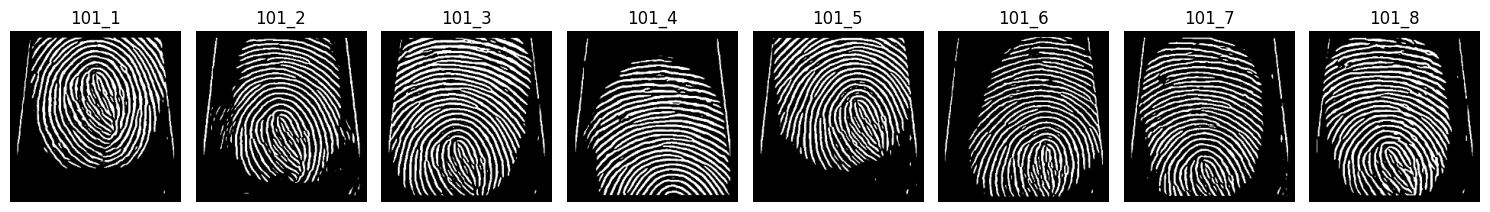

In [14]:
import matplotlib.pyplot as plt

# Function to display images for a specific finger ID
def display_finger_images(finger_id, fingerprint_images):
    if finger_id not in fingerprint_images:
        print(f"Finger ID {finger_id} not found!")
        return

    images = fingerprint_images[finger_id]
    num_images = len(images)
    
    # Plot images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        print(img.shape)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{finger_id}_{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example: Display images for finger ID '101'
display_finger_images("101", fingerprint_images)


In [15]:
import random
import itertools
import numpy as np

# Generate positive and negative pairs
def generate_pairs(fingerprint_images):
    positive_pairs = []
    negative_pairs = []
    labels = []  # 1 for positive, 0 for negative

    print("Generating positive pairs...")

    # Generate positive pairs (same finger)
    for finger_id, impressions in fingerprint_images.items():
        for i in range(len(impressions)):
            for j in range(i + 1, len(impressions)):  # Pair each image with others of the same finger
                positive_pairs.append((impressions[i], impressions[j]))
                labels.append(1)

    print(f"Total Positive Pairs: {len(positive_pairs)}")

    print("Generating all possible negative pairs...")

    # Generate all possible negative pairs (cross-finger pairs)
    all_finger_ids = list(fingerprint_images.keys())
    for finger_id_1, finger_id_2 in itertools.combinations(all_finger_ids, 2):
        for img1 in fingerprint_images[finger_id_1]:
            for img2 in fingerprint_images[finger_id_2]:
                negative_pairs.append((img1, img2))
                labels.append(0)

    print(f"Total Negative Pairs Before Sampling: {len(negative_pairs)}")

    # Shuffle all negative pairs
    random.shuffle(negative_pairs)

    # Match the number of positive pairs
    negative_pairs = negative_pairs[:len(positive_pairs)]
    labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

    print(f"Total Negative Pairs After Sampling: {len(negative_pairs)}")
    print(f"Total Pairs: {len(positive_pairs) + len(negative_pairs)}")

    # Combine positive and negative pairs
    all_pairs = positive_pairs + negative_pairs

    # Shuffle the final pairs and labels together
    combined = list(zip(all_pairs, labels))
    random.shuffle(combined)

    all_pairs, labels = zip(*combined)

    return np.array(all_pairs), np.array(labels), negative_pairs, positive_pairs


In [16]:
pairs, labels,negative_pairs,positive_pairs = generate_pairs(fingerprint_images)
print(f"Generated {len(pairs)} pairs.")

Generating positive pairs...
Total Positive Pairs: 840
Generating all possible negative pairs...
Total Negative Pairs Before Sampling: 27840
Total Negative Pairs After Sampling: 840
Total Pairs: 1680
Generated 1680 pairs.


In [17]:
from sklearn.model_selection import train_test_split
train_pairs, test_pairs, train_labels, test_labels = train_test_split(pairs, labels, test_size=0.2, random_state=42)

In [18]:
# Separate pairs into two arrays for input
train_images_1 = np.array([pair[0] for pair in train_pairs])
train_images_2 = np.array([pair[1] for pair in train_pairs])
test_images_1 = np.array([pair[0] for pair in test_pairs])
test_images_2 = np.array([pair[1] for pair in test_pairs])

# Normalize the images
train_images_1 = train_images_1 / 255.0
train_images_2 = train_images_2 / 255.0
test_images_1 = test_images_1 / 255.0
test_images_2 = test_images_2 / 255.0

In [19]:
print(f"train_images {len(train_images_1)}")
print(f"test_images {len(test_images_1)}")

train_images 1344
test_images 336


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import os


In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Lambda, Dense, Dropout, Concatenate, GlobalAveragePooling2D, Input
import numpy as np

# Define the Base Network (ResNet50 feature extractor)
def create_base_network(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Fine-tune ResNet50 (not frozen like in the original code)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    return Model(inputs=base_model.input, outputs=x)

# Define Siamese Network
def siamese_network(input_shape):
    # Inputs
    input_1 = layers.Input(shape=input_shape)
    input_2 = layers.Input(shape=input_shape)

    # Shared feature extractor (ResNet50)
    base_network = create_base_network(input_shape)
    h1 = base_network(input_1)
    h2 = base_network(input_2)

    # Distance metrics: dot product, difference squared
    dot_product = Lambda(lambda tensors: tf.multiply(tensors[0], tensors[1]))([h1, h2])
    diff = Lambda(lambda tensors: tensors[0] - tensors[1])([h1, h2])
    diff_squared = Lambda(lambda x: tf.square(x))(diff)

    # Concatenate features (dot_product, diff_squared)
    concatenated = Concatenate()([dot_product, diff_squared])

    # Fully connected layers
    x = Dense(1024, activation='relu')(concatenated)  # Increased size to match the second code's dense layers
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)  

    # Model
    model = Model(inputs=[input_1, input_2], outputs=output)
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [23]:
input_shape = (224, 224, 3)
model = siamese_network(input_shape)

# Train the model
history = model.fit([train_images_1, train_images_2], train_labels, batch_size=16, epochs=200, validation_split=0.2)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 126s 915ms/step - accuracy: 0.5332 - loss: 0.7863 - val_accuracy: 0.5167 - val_loss: 0.7241
Epoch 2/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - accuracy: 0.7750 - loss: 0.4388 - val_accuracy: 0.5428 - val_loss: 0.7194
Epoch 3/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 316ms/step - accuracy: 0.9437 - loss: 0.1622 - val_accuracy: 0.5130 - val_loss: 2.1819
Epoch 4/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - accuracy: 0.9389 - loss: 0.1555 - val_accuracy: 0.5167 - val_loss: 2.4883
Epoch 5/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 341ms/step - accuracy: 0.9599 - loss: 0.0924 - val_accuracy: 0.5167 - val_loss: 3.1219
Epoch 6/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 351ms/step - accuracy: 0.9834 - loss: 0.0486 - val_accuracy: 0.6543 - val_loss: 1.1033
Epoch 7/200
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 339ms/step - accuracy: 0.9922 - loss: 0.0308 - val_accuracy: 0.9405 - val_loss: 0.2419
Epoch 8/200
68/68 ━━━━━━━━━━━━━━━━━━━━

In [37]:
# Generate predictions
y_pred_prob = model.predict([test_images_1, test_images_2])  # Replace test_images_1 and test_images_2 with your test inputs
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


In [25]:
len(test_labels)

336

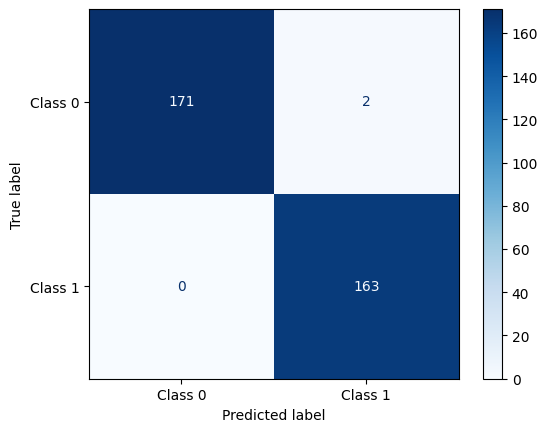

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')


In [41]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

# Extract the values from the confusion matrix
tn, fp, fn, tp = cm.ravel()  # Unpack True Negatives, False Positives, False Negatives, and True Positives

# Calculate accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision= (tp ) / (tp + fp)
recall = (tp)  / (tp + fn)
print(f"Accuracy: {accuracy:.2f} Precision:{precision:.2f} Recall: {recall:.2f}")


Accuracy: 0.99 Precision:0.99 Recall: 1.00


In [ ]:
# Save the weights to a file
model.save_weights('siamese_weights_3.weights.h5')

print("Model weights saved to siamese_weights_3.h5")


In [ ]:
testing=model.predict([test_images_1[0:5], test_images_2[0:5]])

In [ ]:
(testing>0.5).astype(int)

In [ ]:
test_labels[0:5]

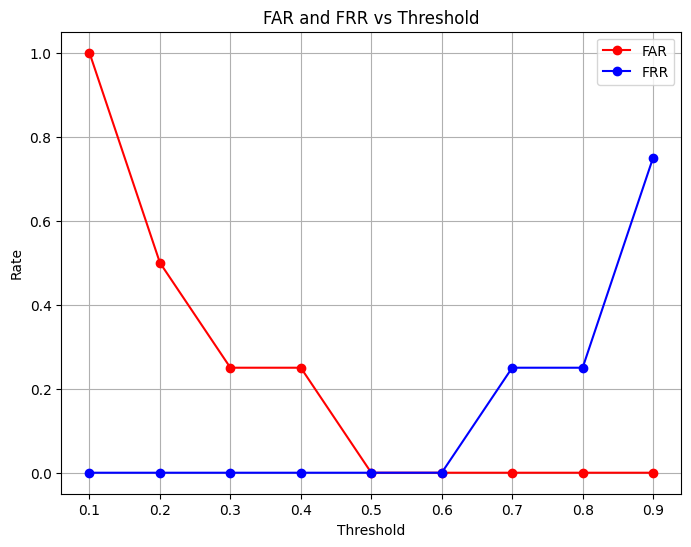

Threshold: 0.1, FAR: 1.00, FRR: 0.00
Threshold: 0.2, FAR: 0.50, FRR: 0.00
Threshold: 0.3, FAR: 0.25, FRR: 0.00
Threshold: 0.4, FAR: 0.25, FRR: 0.00
Threshold: 0.5, FAR: 0.00, FRR: 0.00
Threshold: 0.6, FAR: 0.00, FRR: 0.00
Threshold: 0.7, FAR: 0.00, FRR: 0.25
Threshold: 0.8, FAR: 0.00, FRR: 0.25
Threshold: 0.9, FAR: 0.00, FRR: 0.75


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Ground truth labels and predicted probabilities (for illustration purposes)
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 0])
y_pred_probs = np.array([0.9, 0.1, 0.8, 0.7, 0.2, 0.85, 0.4, 0.1])

# Define multiple thresholds to evaluate
thresholds = np.arange(0.1, 1.0, 0.1)

# Lists to store FAR and FRR for each threshold
fars = []
frrs = []

# Loop over each threshold
for threshold in thresholds:
    # Convert predicted probabilities to binary predictions
    y_pred = (y_pred_probs >= threshold).astype(int)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate FAR and FRR
    far = fp / (fp + tn)
    frr = fn / (fn + tp)
    
    # Append results to lists
    fars.append(far)
    frrs.append(frr)

# Plot FAR and FRR vs Thresholds
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fars, label='FAR', color='red', marker='o')
plt.plot(thresholds, frrs, label='FRR', color='blue', marker='o')

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('FAR and FRR vs Threshold')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Print FAR and FRR for each threshold
for threshold, far, frr in zip(thresholds, fars, frrs):
    print(f"Threshold: {threshold:.1f}, FAR: {far:.2f}, FRR: {frr:.2f}")
